In [1]:
# импорт базовых модулей
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [119]:
# импорт дополнительных модулей
import math
import sklearn.model_selection as skl_ms
import sklearn.linear_model as skl_lm
import sklearn.metrics as skl_mt
import sklearn.neighbors as skl_nb
import sklearn.naive_bayes as skl_ba
import sklearn.ensemble as skl_en
from scipy import stats

# Загрузка датасета и знакомство

In [3]:
# тренировочный датасет
train = pd.read_csv('train.csv', index_col='client_id', parse_dates=['app_date'])
train.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
client_id,,,,,,,,,,,,,,,,,,
25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [170]:
test = pd.read_csv('test.csv', index_col='client_id', parse_dates=['app_date'])
test.shape[0] / train.shape[0]

0.49254054932993674

**индекс**
- client_id - идентификатор клиента

**признаки**
- app_date - дата подачи заявки
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- score_bki - скоринговый балл по данным из БКИ
- bki_request_cnt - количество запросов в БКИ
- region_rating - рейтинг региона
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- foreign_passport - наличие загранпаспорта

**целевая переменная**
- default - флаг дефолта по кредиту

In [4]:
# общая информация по датасету
train.info()
# Данных достаточно много
# Есть пропуски в education
# Не все признаки числовые

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 25905 to 15796
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   app_date          73799 non-null  datetime64[ns]
 1   education         73492 non-null  object        
 2   sex               73799 non-null  object        
 3   age               73799 non-null  int64         
 4   car               73799 non-null  object        
 5   car_type          73799 non-null  object        
 6   decline_app_cnt   73799 non-null  int64         
 7   good_work         73799 non-null  int64         
 8   score_bki         73799 non-null  float64       
 9   bki_request_cnt   73799 non-null  int64         
 10  region_rating     73799 non-null  int64         
 11  home_address      73799 non-null  int64         
 12  work_address      73799 non-null  int64         
 13  income            73799 non-null  int64         
 14  sna               

In [5]:
# возможные значения нечисловых признаков
for f in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    print(train[f].unique())
# Education - категориальный, точная расшифровка неясна
# Sex - категориальный
# Остальные - бинарные

['SCH' 'GRD' 'UGR' 'PGR' 'ACD' nan]
['M' 'F']
['Y' 'N']
['Y' 'N']
['N' 'Y']


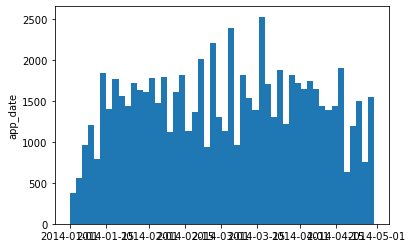

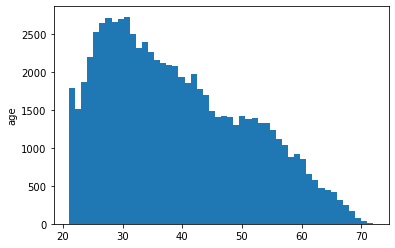

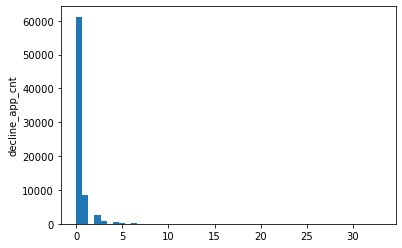

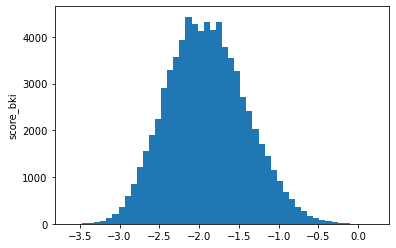

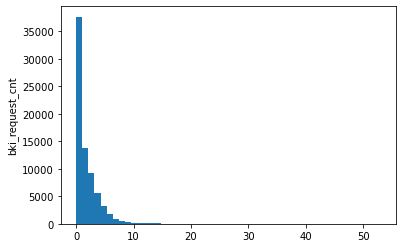

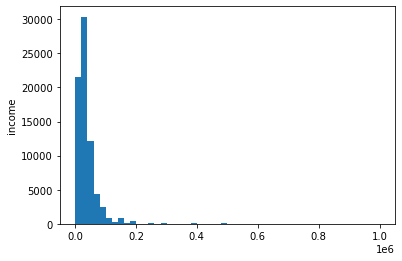

In [6]:
# распределение численных признаков
for f in ['app_date', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']:
    plt.hist(train[f], bins=50)
    plt.ylabel(f)
    plt.show()
# score_bki - довольно нормальная

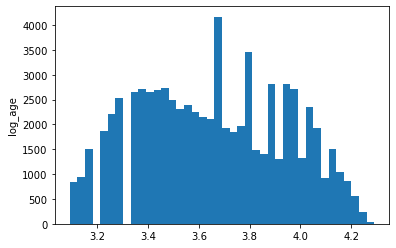

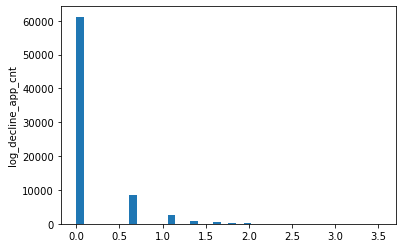

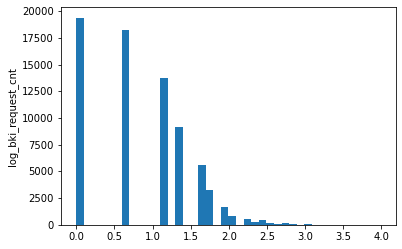

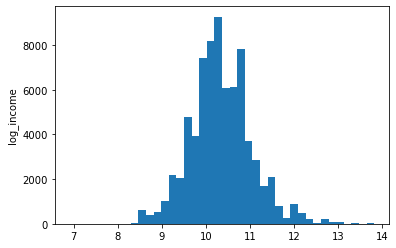

In [7]:
# распределение отдельных численных признаков в логарифмической шкале
for f in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    plt.hist(np.log(train[f]+1), bins=40)
    plt.ylabel('log_'+f)
    plt.show()
# income - стала нормальнее

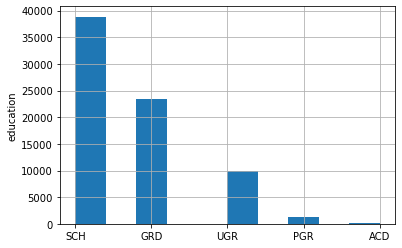

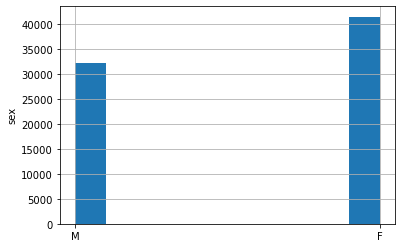

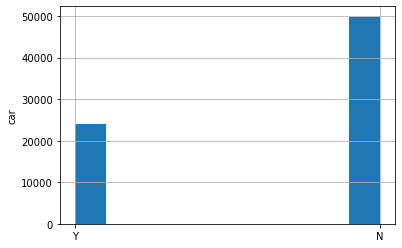

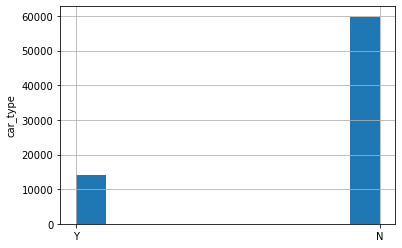

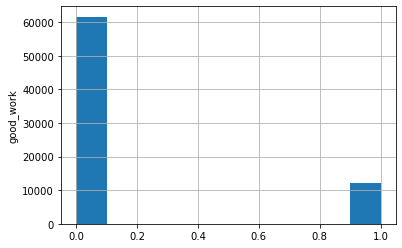

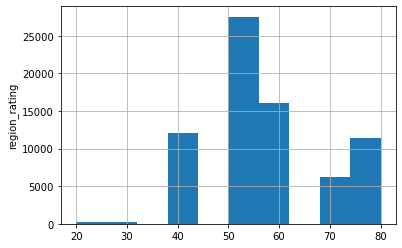

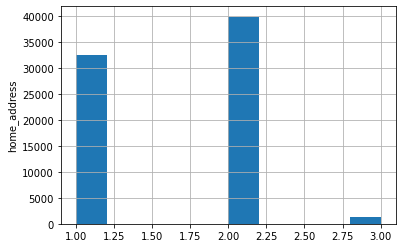

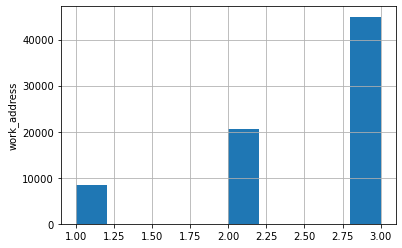

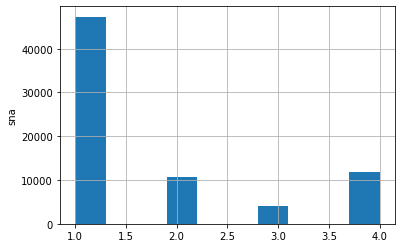

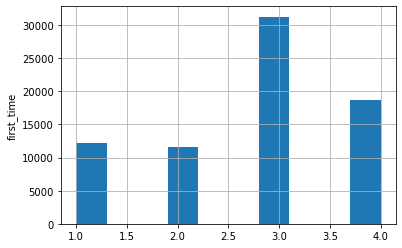

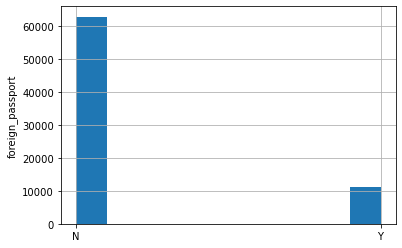

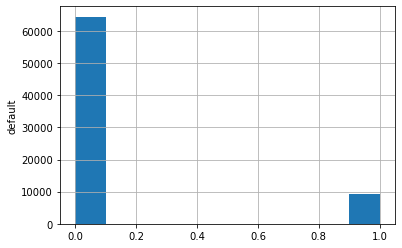

In [8]:
# распределение бинарных и категориальных признаков, включая целевую переменной
for f in ['education', 'sex', 'car', 'car_type', 'good_work', 
          'region_rating', 'home_address', 'work_address', 
          'sna', 'first_time', 'foreign_passport', 'default']:
    train[f].hist()
    plt.ylabel(f)
    plt.show()
# видна несбалансированность по целевой переменной

In [9]:
# проверим, нет ли конфликта между car и car_type
print(((train['car'] == 'N') & (train['car_type'] == 'Y')).sum())
# конфликта нет, наверное, имеет смысл сделать единый категориальный признак

0


<AxesSubplot:>

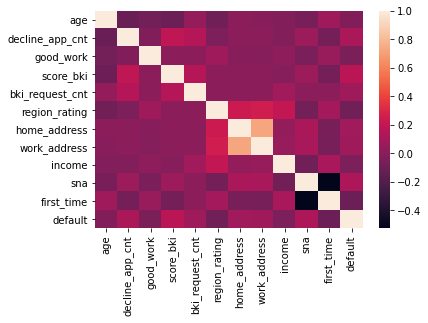

In [10]:
# корреляции
sns.heatmap(train.corr())
# явной корреляции не вижу
# home_address и work_address разве что

# Предобработка данных

In [11]:
train.columns

Index(['app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [164]:
def preprocess_data(df):
    df_out = df.copy()

    # объединим car и car_type в один категориальный признак
    df_out['car'] = (df_out['car'].replace({'N': 0, 'Y': 1}) + df_out['car_type'].replace(
        {'N': 0, 'Y': 2})).replace({0: 'no', 1: 'rus', 2: 'error', 3: 'imp'})
    df_out.drop(columns='car_type', inplace=True)

    # заполним пропуск в education
    df_out['education'].fillna(value=df_out['education'].mode()[0], inplace=True)

    # логические в цифровые
    bool_features = ['good_work', 'foreign_passport']
    df_out[bool_features] = df_out[bool_features].replace({'N': 0, 'Y': 1})
    
    # категориальные в индикативные
#     cat_features = ['education', 'sex', 'car', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
    cat_features = ['education', 'sex', 'car', 'home_address', 'work_address', 'sna', 'first_time']
    df_out = pd.get_dummies(df_out, columns=cat_features)
    
    # преобразуем дату в давность
    max_date = pd.to_datetime('2015-01-01') # magic datetime :(
    df_out['n_days_ago'] = (df_out['app_date'] - max_date).dt.days
    df_out.drop(columns='app_date', inplace=True)
    
    # удалим оценку БКИ
    df_out.drop(columns='score_bki', inplace=True)
    
    # генерируем новые признаки
    # логарифм зарплаты
    df_out['log_income'] = df_out['income'].apply('log')
    df_out.drop(columns='income', inplace=True)
    # логарифм возраста
    df_out['log_age'] = df_out['age'].apply('log')
    df_out.drop(columns='age', inplace=True)
    # логарифм числа запросов в БКИ
#     df_out['log_bki_request_cnt'] = (df_out['bki_request_cnt'] + 1).apply('log')

    # добавим случайный признак, чтобы сравнивать влияние
    dist = stats.bernoulli(0.5) # расппределение Бернулли (0 или 1) с вероятностью 0.5
    df_out['random'] = dist.rvs(df_out.shape[0])
    
    # попробуем уменьшить память на int64
    for f in df_out.select_dtypes(include='int64').columns:
        df_out[f] = pd.to_numeric(df_out[f], downcast='integer')
    # попробуем уменьшить память на float64
    for f in df_out.select_dtypes(include='float64').columns:
        df_out[f] = pd.to_numeric(df_out[f], downcast='float')
    
    return df_out

In [165]:
# обработаем датасет и разделим на признаки и целевую переменную
train_proc = preprocess_data(train)
X = train_proc.drop(columns=['default'])
y = train_proc['default']
print(X.shape, y.shape)

(73799, 33) (73799,)


In [166]:
# разделим на обучающую и валидационную выборку
X_train, X_valid, y_train, y_valid = skl_ms.train_test_split(X, y, train_size=0.7, random_state=73, stratify=y)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(51659, 33) (51659,)
(22140, 33) (22140,)


# Выбор потенциальных моделей

**Кандидаты моделей для задачи классификации**
- Logistic regression
- K-NN
- Naive Bayes
- Decision tree ensemble

Прогоним методы с параметрами по умолчанию. Проверим по критерию f1. Выберем потенциально рабочие.

In [147]:
# Метрика f1 для случайной величины
print('f1 random:', skl_mt.f1_score(y_train, X_train['random']))

f1 random: 0.2012516264948262


## Логистическая регрессия

In [148]:
logit_1 = skl_lm.LogisticRegression(random_state=73, max_iter=1000)
logit_1.fit(X_train, y_train)
y_train_pred = logit_1.predict(X_train)
y_valid_pred = logit_1.predict(X_valid)
print('f1 train:', skl_mt.f1_score(y_train, y_train_pred))
print('f1 valid:', skl_mt.f1_score(y_valid, y_valid_pred))
# ужасно

f1 train: 0.024307099451608125
f1 valid: 0.026878015161957272


## K-NN

In [150]:
knn_1 = skl_nb.KNeighborsClassifier(n_neighbors=7, n_jobs=16)
knn_1.fit(X_train, y_train)
y_train_pred = knn_1.predict(X_train)
y_valid_pred = knn_1.predict(X_valid)
print('f1 train:', skl_mt.f1_score(y_train, y_train_pred))
print('f1 valid:', skl_mt.f1_score(y_valid, y_valid_pred))
# лучше, чем logit, но всё равно ужасно

f1 train: 0.15737530008002135
f1 valid: 0.07930607187112763


## Наивный Байес

In [167]:
nb_1 = skl_ba.BernoulliNB()
nb_1.fit(X_train, y_train)
y_train_pred = nb_1.predict(X_train)
y_valid_pred = nb_1.predict(X_valid)
print('f1 train:', skl_mt.f1_score(y_train, y_train_pred))
print('f1 valid:', skl_mt.f1_score(y_valid, y_valid_pred))
# лучше, чем random

f1 train: 0.24054808424257804
f1 valid: 0.24617796942375542


## Случайный лес

In [168]:
forrest_1 = skl_en.RandomForestClassifier(n_estimators=5)
forrest_1.fit(X_train, y_train)
y_train_pred = forrest_1.predict(X_train)
y_valid_pred = forrest_1.predict(X_valid)
print('f1 train:', skl_mt.f1_score(y_train, y_train_pred))
print('f1 valid:', skl_mt.f1_score(y_valid, y_valid_pred))
# уже хорошо на обучающей выборке, но плохо на валидационной
# причем параметр 5 даёт лучшую валидационную оценку

f1 train: 0.903580814717477
f1 valid: 0.1384260446039477


<AxesSubplot:>

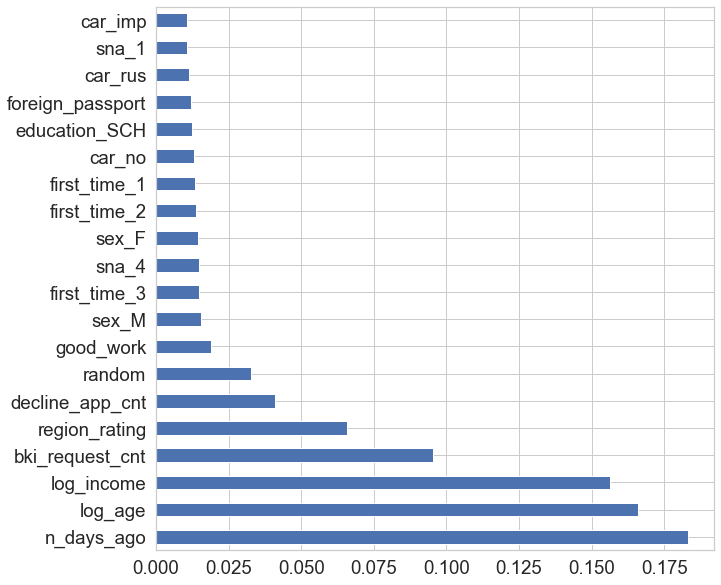

In [169]:
# посмотрим самые важные признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(forrest_1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Предварительные выводы
Потенциально адекватными показали себя Наивный Байес и Случайный лес. С ними можно дальше работать.